In [1]:
# testing consequences of interventions on gpt2, and how they match up against our SAE's
import datasets
import seaborn as sns
import torch
import torch.nn.functional as F
from einops import einsum
from safetensors.torch import load_file
from tqdm import tqdm
from transformers import AutoTokenizer

from sae.data import chunk_and_tokenize


In [2]:
ckpt_path = "/home/sid/tensor-sae/checkpoints/all-layer-test/sae.safetensors"

In [7]:
from functools import partial

from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2").cuda()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

sae_ckpt = load_file(ckpt_path, device="cuda")

feature_encoder_weights = sae_ckpt["encoder.weight"]
feature_encoder_bias = sae_ckpt["encoder.bias"]
# legacy keys
feature_decoder_weights = sae_ckpt["decoder.weight"]
feature_decoder_bias = sae_ckpt["decoder.bias"]

intervention_index = 5
readout_index = 8


def create_hooks(
    model,
    intervention_index,
    readout_index,
    lambda_value,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
):
    first_activation_positions = None
    consequent_embeddings = None
    causal_embeddings = None
    v_j = None
    v_k = None

    def strengthen_sae_feature(module, input, output, layer_offset=0):
        nonlocal first_activation_positions, causal_embeddings, v_j, v_k

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]

        feature_activation = (
            einsum(output[0], feature_encoder_segment.T, "b s e, e n -> b s n")
            - feature_encoder_bias
        )
        feature_activation, max_feature_index = torch.max(feature_activation, dim=-1)

        first_activation_positions = (feature_activation > 0).float().argmax(dim=1)
        has_activation = (feature_activation > 0).any(dim=1)
        first_activation_positions[~has_activation] = -1

        batch_size, seq_len, embed_dim = output[0].shape

        mask = torch.arange(seq_len, device=output[0].device).unsqueeze(0).expand(
            batch_size, -1
        ) == first_activation_positions.unsqueeze(1)

        causal_embeddings = output[0]
        mask = mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        v_k = (
            feature_decoder_segment.unsqueeze(0)
            .expand(output[0].shape[0], -1, -1)
            .gather(
                1, max_feature_index.unsqueeze(-1).expand(-1, -1, embed_dim)
            )
        )
        new_output = output[0] + lambda_value * mask * v_k

        intervention_decoder_segment = feature_decoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        v_j = (
            intervention_decoder_segment.unsqueeze(0)
            .expand(output[0].shape[0], -1, -1)
            .gather(
                1, max_feature_index.unsqueeze(-1).expand(-1, -1, embed_dim)
            )
        )

        new_outputs = [new_output] + list(output[1:])
        return tuple(new_outputs)

    def return_consequent_layer(module, input, output):
        nonlocal consequent_embeddings, first_activation_positions

        batch_size, seq_len, embed_dim = output[0].shape

        mask = torch.arange(seq_len, device=output[0].device).unsqueeze(0).expand(
            batch_size, -1
        ) == first_activation_positions.unsqueeze(1)
        mask = mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        filtered_output = output[0]
        consequent_embeddings = filtered_output.sum(dim=1)

        # Return the original output unchanged
        return output

    intervention_hook = model.transformer.h[intervention_index].register_forward_hook(
        partial(strengthen_sae_feature, layer_offset=intervention_index)
    )
    readout_hook = model.transformer.h[readout_index].register_forward_hook(
        return_consequent_layer
    )

    return (
        intervention_hook,
        readout_hook,
        lambda: first_activation_positions,
        lambda: consequent_embeddings,
        lambda: causal_embeddings,
        lambda: v_j,
        lambda: v_k,
    )


def process_text(
    model,
    inputs,
    intervention_index,
    readout_index,
    lam,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
):
    (
        intervention_hook,
        readout_hook,
        get_first_activation_positions,
        get_consequent_embeddings,
        get_causal_embeddings,
        get_v_j,
        get_v_k,
    ) = create_hooks(
        model,
        intervention_index,
        readout_index,
        lam,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
    )

    with torch.no_grad():
        model(**inputs)

    first_activation_positions = get_first_activation_positions()
    consequent_embeddings = get_consequent_embeddings()
    causal_embeddings = get_causal_embeddings()
    v_j = get_v_j()
    v_k = get_v_k()

    intervention_hook.remove()
    readout_hook.remove()

    return (
        first_activation_positions,
        consequent_embeddings,
        causal_embeddings,
        v_j,
        v_k,
    )


# Example usage
intervention_index = 5
readout_index = 8
text = ["Hello, world!", "Hello, world!"]
inputs = tokenizer(text, return_tensors="pt").to("cuda")

# Assuming you have these variables defined
# feature_encoder_weights, feature_encoder_bias, feature_decoder_weights

first_activation_positions, consequent_embeddings, causal_embeddings, _, _= process_text(
    model,
    inputs,
    intervention_index,
    readout_index,
    1.0,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
)

print(f"shape of output embeddings: {consequent_embeddings.shape}")
print(f"shape of causal embeddings: {causal_embeddings.shape}")

shape of output embeddings: torch.Size([2, 768])
shape of causal embeddings: torch.Size([2, 4, 768])


In [8]:
#next code we would need to add:
#filter out any batch elements where the SAE doesn't trigger
#compare to activations from a hook on the clean sequence
#subtract, compute comparisons, etc.!

In [9]:
#I suspect the most efficient way to go about thos jacobian computation is to modify the gpt2 forward pass

In [10]:
model.transformer.h

ModuleList(
  (0-11): 12 x GPT2Block(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2SdpaAttention(
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (resid_dropout): Dropout(p=0.1, inplace=False)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D()
      (c_proj): Conv1D()
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [33]:
def compute_jacobian(model, j_activations, i, j, k):
    """
    Compute the Jacobian of layer k's activations with respect to layer j's activations at position i.

    Args:
    - model: GPT2Model instance
    - j_activations: activations of layer j (shape: [batch_size, seq_len, hidden_size])
    - i: token position
    - j: index of the input layer
    - k: index of the output layer

    Returns:
    - Jacobian matrix
    """
    # Ensure j_activations requires grad
    j_activations.requires_grad_(True)

    # Forward pass to get k_activations
    def forward_to_k(x):
        # Forward pass from j to k
        activations = x
        for layer_idx in range(j, k + 1):
            activations = model.transformer.h[layer_idx](activations)[0]
        return activations[:, i, :]

    # Compute Jacobian
    jacobian = torch.autograd.functional.jacobian(forward_to_k, j_activations)

    return jacobian.squeeze(0, 2)[:, i, :]  # selecting only token pos i.
    # But if we're pre-computing, we could just return the jacobian.squeeze(0,2)

In [34]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
).select(range(16))
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=64)

num_proc must be <= 16. Reducing num_proc to 16 for dataset of size 16.


In [35]:
tokenized

Dataset({
    features: ['input_ids', 'overflow_to_sample_mapping'],
    num_rows: 4299
})

In [36]:
# Collect activations from GPT2
sample = tokenized[0]["input_ids"]
j, k = 5, 8
lam = 1e-9
(first_activation_positions, consequent_embeddings, causal_embeddings, v_j, v_k) = (
    process_text(
        model,
        {
            "input_ids": sample.cuda(),
            "attention_mask": torch.ones_like(sample, device="cuda:1"),
        },
        j,
        k,
        lam,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
    )
)

In [37]:
causal_embeddings.shape

torch.Size([1, 64, 768])

In [38]:
# Generate random input
# batch_size, seq_len = 1, 10
# j_activations = torch.randn(batch_size, seq_len, 768, device="cuda:1")

# Compute Jacobian for predicting layer 5 activations from layer 3 activations at position 2
i, j, k = 2, 3, 5
jacobian = compute_jacobian(model, causal_embeddings, i, j, k)

print(f"Jacobian shape: {jacobian.shape}")

torch.Size([1, 768, 1, 64, 768])
Jacobian shape: torch.Size([768, 768])


In [18]:
# Compare jacobian and local approximation
with torch.no_grad():
    jacobian_approx = causal_embeddings[:, i, :] + jacobian * v_j[:, i, :] * lam
    local_approx = causal_embeddings[:, i, :] + v_j[:, i, :] * lam

In [19]:
torch.norm(jacobian_approx - local_approx)

tensor(0., device='cuda:0')

In [20]:
def get_active_latents_first_pos(
    output, feature_encoder_weights, feature_encoder_bias, i, j
):
    # concat hidden states for layer range
    all_hidden_states = torch.cat(
        [output.hidden_states[idx] for idx in range(i, j + 1)], dim=-1
    )
    feature_activation = (
        einsum(all_hidden_states, feature_encoder_weights.T, "b s e, e n -> b s n")
        - feature_encoder_bias
    )
    max_feature_activation, _ = torch.max(feature_activation, dim=-1)
    # get first positions where maximal feature is activated
    first_activation_positions = (
        (max_feature_activation > 0).float().argmax(dim=1, keepdim=True)
    )
    expanded_pos = first_activation_positions.unsqueeze(-1).expand(
        -1, -1, all_hidden_states.shape[-1]
    )
    token_activations = all_hidden_states.gather(1, expanded_pos)
    num_fired = (token_activations > 0).sum(dim=-1)

    return num_fired

In [21]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=128)

In [22]:
# Define, lower and upper bounds for layers
i, j = 0, 11

100%|██████████| 64/64 [01:38<00:00,  1.54s/it]


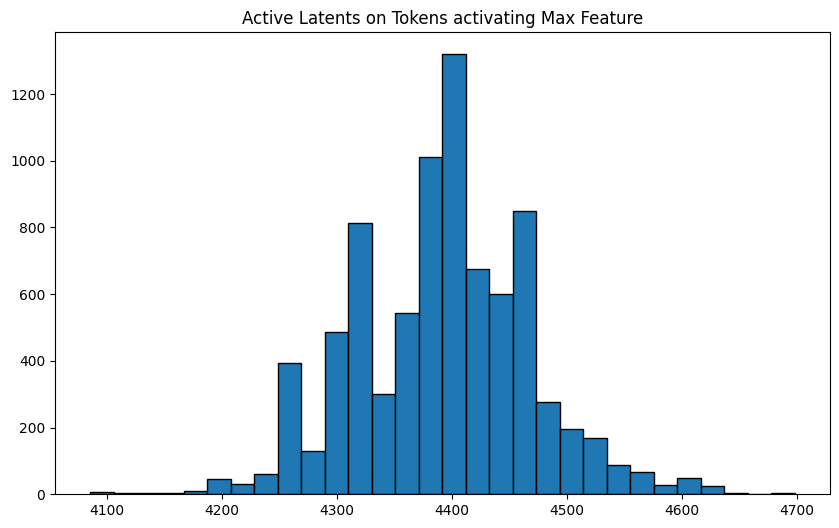

In [23]:
import gc

import matplotlib.pyplot as plt

num_samples = 8192
bsz = 128
# for each sample compute activation positions and fired pre-act latents
sample = tokenized.select(range(num_samples))

dist = []

for batch in tqdm(sample.iter(bsz), total=num_samples // bsz):
    with torch.no_grad():
        out = model(
            input_ids=batch["input_ids"].cuda().unsqueeze(0), output_hidden_states=True
        )
    num_active = get_active_latents_first_pos(
        out, feature_encoder_weights, feature_encoder_bias, i, j
    )
    dist.extend(num_active.squeeze().cpu().tolist())

torch.cuda.empty_cache()
gc.collect()


# Create the histogram
plt.figure(figsize=(10, 6))
plt.title("Active Latents on Tokens activating Max Feature")
_ = plt.hist(dist, bins=30, edgecolor="black")

In [24]:
def get_active_latents_heatmap(
    output, feature_encoder_weights, feature_encoder_bias, i, j
):
    # Concatenate hidden states for layer range
    all_hidden_states = torch.cat(
        [output.hidden_states[idx] for idx in range(i, j + 1)], dim=-1
    )

    # Calculate feature activation
    feature_activation = (
        torch.einsum("bse,en->bsn", all_hidden_states, feature_encoder_weights.T)
        - feature_encoder_bias
    )

    # Count number of active latents for each token
    num_active_latents = (feature_activation > 0).sum(dim=-1)

    return num_active_latents


def visualize_heatmap_batch(heatmap_data, token_labels_batch, max_tokens_display=30):
    batch_size, seq_length = heatmap_data.shape

    # Create a figure with subplots for each batch item
    fig, axes = plt.subplots(batch_size, 1, figsize=(20, 3 * batch_size), squeeze=False)
    fig.suptitle("Active Latents Heatmap (Batch)", fontsize=16)

    for b in range(batch_size):
        ax = axes[b, 0]

        # Limit the number of tokens displayed
        display_tokens = min(seq_length, max_tokens_display)
        heatmap = heatmap_data[b, :display_tokens].unsqueeze(0).cpu().numpy()
        token_labels = token_labels_batch[b][:display_tokens]

        sns.heatmap(
            heatmap,
            cmap="YlOrRd",
            xticklabels=token_labels,
            yticklabels=[""],
            ax=ax,
            cbar=(b == batch_size - 1),
        )  # Only show colorbar for the last subplot

        ax.set_title(f"Batch item {b}")
        ax.set_xlabel("Tokens")

        # Rotate and align x-axis labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

        # Add ellipsis if not all tokens are displayed
        if display_tokens < seq_length:
            ax.text(
                display_tokens + 0.5,
                0.5,
                "...",
                verticalalignment="center",
                horizontalalignment="left",
            )

    plt.tight_layout()
    plt.show()

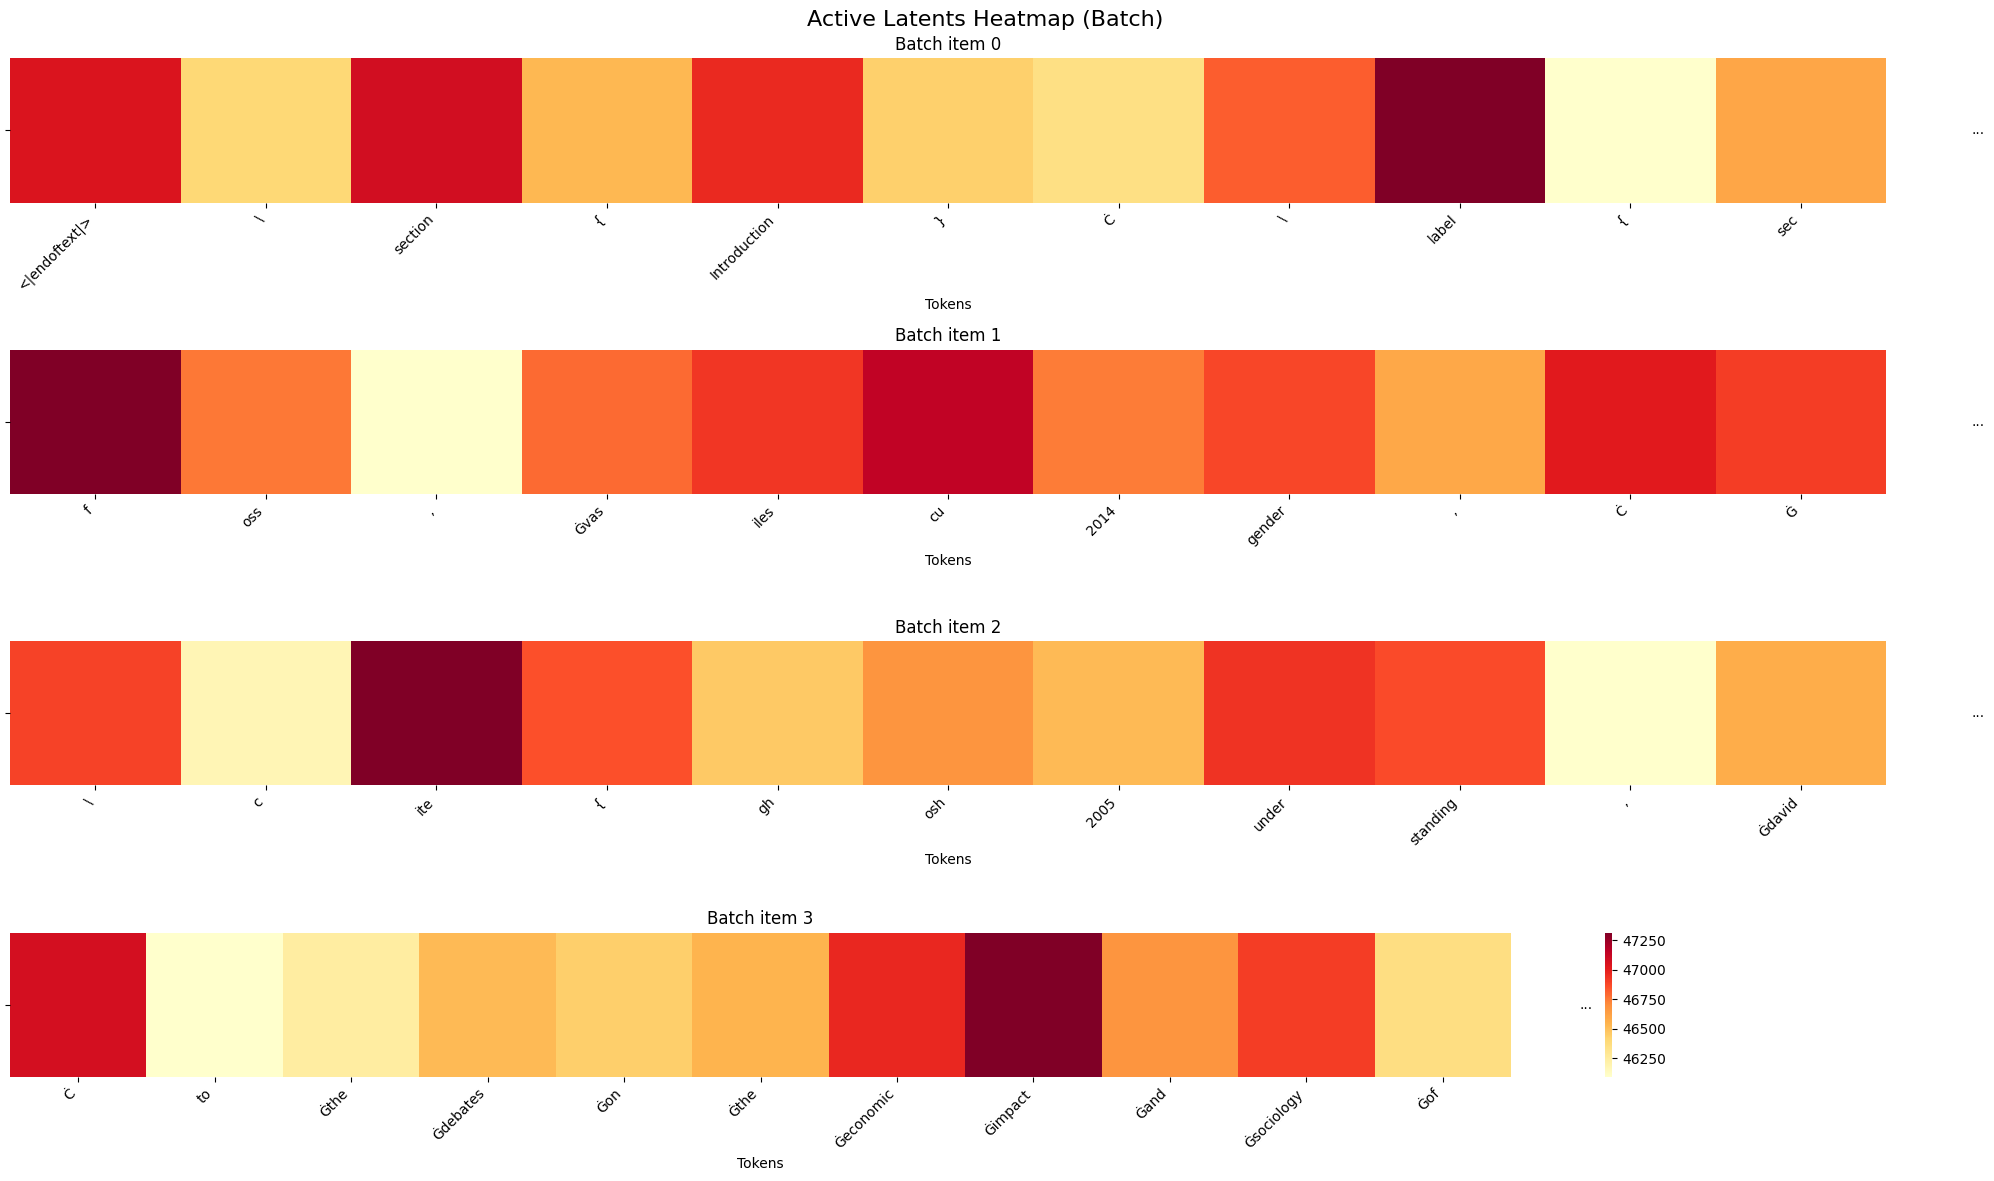

In [25]:
sample_input = tokenized.select(range(4))
out = model(input_ids=sample_input["input_ids"].cuda(), output_hidden_states=True)

active_latents_tokenwise = get_active_latents_heatmap(
    out, feature_encoder_weights, feature_encoder_bias, i, j
)
visualize_heatmap_batch(
    active_latents_tokenwise,
    [tokenizer.convert_ids_to_tokens(x) for x in sample_input["input_ids"]],
j)

In [66]:
def compute_causal_attribution_strength(
    j,
    k,
    model,
    inputs,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value: float = 1.0,
):
    first_activation_positions, consequent_embeddings, causal_embeddings, v_j, v_k = (
        process_text(
            model,
            inputs,
            intervention_index,
            readout_index,
            lambda_value,
            feature_encoder_weights,
            feature_encoder_bias,
            feature_decoder_weights,
        )
    )

    expanded_pos = (
        first_activation_positions.unsqueeze(-1)
        .unsqueeze(-1)
        .expand(-1, -1, causal_embeddings.shape[-1])
    )
    v_j = v_j.gather(1, expanded_pos).squeeze(1)
    v_k = v_k.gather(1, expanded_pos).squeeze(1)

    jacobian = torch.stack(
        [
            compute_jacobian(
                model, causal_embeddings[idx].unsqueeze(0), pos.item(), j, k
            )
            for idx, pos in enumerate(first_activation_positions)
        ]
    )
    # proportion of causality explained: compute vk.T(v_jJ)/||v_k||^2
    v_k_norm_squared = torch.sum(v_k**2, dim=-1, keepdim=True)  # shape: (B, 1)
    # Compute the whole expression using einsum
    proportion_explained = (
        torch.einsum("be,bee,be->b...", v_j, jacobian, v_k) / v_k_norm_squared
    )
    # error term
    error = torch.einsum("be,bee->be", v_j, jacobian) - v_k_norm_squared
    strength = F.cosine_similarity(error, v_k, dim=-1)

    return proportion_explained, strength

In [67]:
# TODO: unbatch the jacobian 
explained_causality, strengths = compute_causal_attribution_strength(
    intervention_index,
    readout_index,
    model,
    inputs,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    1.0,
)

torch.Size([1, 768, 1, 4, 768])
torch.Size([1, 768, 1, 4, 768])
torch.Size([2, 768]) torch.Size([2, 768, 768]) torch.Size([2, 768])
